# Task
<b>Predict the rating for a given (user_id, movie_id) pair </b>

Predicted rating $\hat{y}_{ij}$ for user i, movied j pair is calcuated as $\hat{y}_{ij} = \mu + b_i + c_j + u_i^T v_j$ , here we will be finding the best values of $b_{i}$ and $c_{j}$ using SGD algorithm with the optimization problem for N users and M movies is defined as

$$
L = \min_{ b, c, \{ u_i \}_{i=1}^N, \{ v_j \}_{j=1}^M}
\quad
\alpha \Big(
    \sum_{j} \sum_{k} v_{jk}^2 
    + \sum_{i} \sum_{k} u_{ik}^2 
    + \sum_{i} b_i^2
    + \sum_{j} c_i^2
    \Big)
+ \sum_{i,j \in \mathcal{I}^{\text{train}}}
    (y_{ij} - \mu - b_i - c_j - u_i^T v_j)^2
$$

<ul>
<li><span class="math">\(\mu\)</span> : scalar mean rating</li>
<li><span class="math">\(b_i\)</span> : scalar bias term for user <span class="math">\(i\)</span></li>
<li><span class="math">\(c_j\)</span> : scalar bias term for movie <span class="math">\(j\)</span></li>
<li><span class="math">\(u_i\)</span> : K-dimensional vector for user <span class="math">\(i\)</span></li>
<li><span class="math">\(v_j\)</span> : K-dimensional vector for movie <span class="math">\(j\)</span></li>
</ul>

 $ \ $


In [1]:
import pandas as pd
data=pd.read_csv('C:/Users/shwer/data/ratings_train.csv')
data.head()

,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


In [2]:
data.shape

(89992, 3)

In [4]:
data['user_id'].nunique()

943

In [5]:
data['item_id'].nunique()

1662

In [6]:
edges = [tuple(x) for x in data.values.tolist()] # storing all the edges in a list form
edges# where 1 part is user_id, next is item_id and last one is movie_rating

[(772, 36, 3),
 (471, 228, 5),
 (641, 401, 4),
 (312, 98, 4),
 (58, 504, 5),
 (235, 727, 5),
 (285, 266, 4),
 (451, 513, 4),
 (436, 661, 5),
 (101, 648, 3),
 (4, 229, 3),
 (159, 174, 4),
 (832, 1141, 4),
 (53, 544, 3),
 (755, 471, 3),
 (886, 1049, 4),
 (931, 574, 2),
 (641, 582, 4),
 (585, 181, 3),
 (853, 456, 3),
 (439, 359, 5),
 (518, 325, 4),
 (109, 10, 4),
 (624, 143, 4),
 (663, 526, 5),
 (803, 652, 3),
 (730, 601, 5),
 (898, 27, 5),
 (333, 512, 4),
 (253, 14, 3),
 (188, 245, 4),
 (502, 751, 1),
 (787, 131, 5),
 (649, 161, 3),
 (129, 1242, 4),
 (398, 341, 2),
 (489, 513, 3),
 (715, 612, 4),
 (896, 431, 4),
 (605, 172, 5),
 (212, 54, 5),
 (628, 85, 5),
 (921, 152, 4),
 (816, 257, 3),
 (853, 533, 3),
 (535, 384, 4),
 (756, 100, 4),
 (268, 854, 5),
 (401, 469, 4),
 (55, 1072, 3),
 (931, 154, 3),
 (319, 544, 4),
 (331, 566, 4),
 (587, 415, 5),
 (392, 408, 4),
 (920, 326, 5),
 (23, 57, 3),
 (547, 117, 5),
 (781, 259, 2),
 (866, 472, 5),
 (576, 557, 3),
 (367, 97, 3),
 (103, 589, 4),
 (8

<img src='https://i.imgur.com/rmUCGMb.jpg' width=200>

In [8]:
# Creating adjacency matrix as per the image above
a=data['user_id'].values
b=data['item_id'].values
c=data['rating'].values

In [9]:
from scipy.sparse import csr_matrix
adjacency_matrix = csr_matrix((c,(a,b)))

In [11]:
adjacency_matrix.shape # here 943 is unique userID and 1681 is item_id(Movie_id)

(943, 1681)

We will Apply SVD decomposition on the Adjaceny matrix  and get three matrices $U, \sum, V$ such that $U \times \sum \times V^T = A$, <br> 
if $A$ is of dimensions $N \times M$ then <br>
U is of $N \times k$, <br>
$\sum$ is of $k \times k$ and <br>
$V$ is $M \times k$ dimensions. <br>

In [12]:
# Reference: https://stackoverflow.com/questions/31523575/get-u-sigma-v-matrix-from-truncated-svd-in-scikit-learn/31528944#31528944
from sklearn.utils.extmath import randomized_svd
import numpy as np 
matrix = adjacency_matrix
U, Sigma, VT = randomized_svd(matrix, n_components=5,n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 5)
(5,)
(1681, 5)


# Finding mean of ratings 

In [13]:
# Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html) link for more details.
def m_u(ratings):
    '''In this function, we will compute mean for all the ratings'''
    mean=ratings.mean()
    return mean

In [14]:
mu=m_u(data['rating'])
print(mu)

3.529480398257623


# Initialize B_i and C_j
<br>Number of rows of adjacent matrix corresponds to user dimensions (B_i) and number of columns of adjacent matrix corresponds to movie dimensions (C_j)

In [15]:
def initialize(dim):
    '''In this function, we will initialize bias value 'B' and 'C'.'''
    Bi=np.zeros(dim.shape[0])
    Cj=np.zeros(dim.shape[1])
    return Bi,Cj

In [16]:
dim=adjacency_matrix # give the number of dimensions for b_i (Here b_i corresponds to users)
b_i,c_j=initialize(dim)
print(len(b_i))
print(len(c_j))


943
1681


# Compute dL/db_i

In [17]:
def derivative_db(user_id,item_id,rating,U,V,mu,alpha):
    '''In this function, we will compute dL/db_i'''
    db_1=2*alpha*b_i[user_id]
    db_2=-2*(rating-mu-b_i[user_id]-c_j[item_id]-np.dot(U[user_id],V.T[item_id]))
    db=db_1+db_2
    return db

# Compute dL/dc_j

In [18]:
def derivative_dc(user_id,item_id,rating,U,V,mu, alpha):
    '''In this function, we will compute dL/dc_j'''
    dc=2*alpha*c_j[item_id]-2*(rating-mu-b_i[user_id]-c_j[item_id]-np.dot(U[user_id],V.T[item_id]))
    return dc

In [19]:
# Compute MSE(Mean Squared error) for predicted ratings
# Reference: https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
from sklearn.metrics import mean_squared_error
epoch=50
r=0.01 # learning rate
alpha=0.1
mse=[] # to store mse value for each epoch
for i in range(1,epoch+1):
    y_pred=[] # to store all predicted values
    for index,row in data.iterrows(): # for each pair of movie and user as row gives give row i.e. record or single row having all rating, userid, itemid
        user_id=row['user_id'] # will give from that row user_id value
        item_id=row['item_id'] # will give from that row movie id value
        rating=row['rating'] # will give from that row rating value
        b_i[user_id]=b_i[user_id]-(r*derivative_db(user_id,item_id,rating,U,VT,mu,alpha)) # finding bi for each user
        c_j[item_id]=c_j[item_id]-(r*derivative_dc(user_id,item_id,rating,U,VT,mu,alpha)) # finding cj for each movie i.e itemid
        y_hat=mu+b_i[user_id]+c_j[item_id]+np.dot(U[user_id],VT.T[item_id]) # rating prediction for each pair of user and movie
        y_pred.append(y_hat) # storing prediction of ratings in empty list y_pred
    a=mean_squared_error(data['rating'].values,np.array(y_pred)) # finding mean square error for each epoch (predicted and actual ratings difference squared error)
    mse.append(a) # storing mean squared error for each epoch in list mse

In [20]:
# Plotting MSE for each epoch where epoch on X_axis and MSE on y-axis
import matplotlib.pyplot as plt
epoch1=[]
for i in range(1,51):
    epoch1.append(i)
print(epoch1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


<function matplotlib.pyplot.show(*args, **kw)>

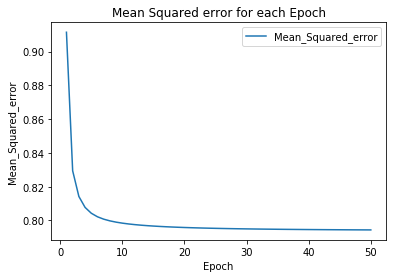

In [21]:
plt.plot(epoch1,mse,label='Mean_Squared_error')
plt.xlabel('Epoch')
plt.ylabel('Mean_Squared_error')
plt.legend()
plt.title("Mean Squared error for each Epoch")
plt.show

# After epoch 20 the MSE decreases at a very very slow rate